# Ćwiczenie 2 - wizualizacja trasy lecącego samolotu

Autor: Michał Ambroży, numer indeksu: 328934

# Wprowadzenie
Celem ćwiczenia jest transformacja współrzędnych elipsoidalnych lecącego samolotu do układu
lokalnego. Danymi do zadania są współrzędne geodezyjne: szerokość φ oraz długość λ, a także
wysokość h samolotu odniesiona do poziomu jednego z lotnisk, podane w pewnych krótkich odstępach czasu. Dane zawarte są w plikach .csv, pobranych z portalu flightradar24.com. Współrzędne te należy przeliczyć najpierw do geocentrycznych współrzędnych ortokartezjańskich, a ostatecznie do układu współrzędnych horyzontalnych (układ lokalny, topocentryczny),
względem znanego położenia lotniska. Należy również wyznaczyć moment, w którym samolot
zniknie poniżej horyzontu (przyjąć moment, kiedy wysokość horyzontalna h = 0). Należy wykonać odpowiednie wizualizacje.


In [237]:
import numpy as np

def read_flightradar(file):
    '''
    Parameters
    ----------
    file : .csv file - format as downloaded from fligthradar24
        DESCRIPTION.
    Returns
    -------
    all_data : numpy array
        columns are:
            0 - Timestamp - ?
            1 - year
            2 - month
            3 - day
            4 - hour
            5 - minute
            6 - second
            7 - Latitude [degrees]
            8 - Longitude [degrees]
            9 - Altitude [feet]
            10 - Speed [?]
            11 - Direction [?]
    '''
    with open(file, 'r') as f:
        i = 0
        size= []
        Timestamp = []; date = []; UTC = []; Latitude = []; Longitude = []; 
        Altitude = []; Speed = []; Direction = []; datetime_date = []
        for linia in f:
            if linia[0:1]!='T':
                splited_line = linia.split(',')
                size.append(len(splited_line))
                i+=1
                Timestamp.append(int(splited_line[0]))
                full_date = splited_line[1].split('T')
                date.append(list(map(int,full_date[0].split('-'))))
                UTC.append(list(map(int, full_date[1].split('Z')[0].split(':'))))
                Callsign = splited_line[2]
                Latitude.append(float(splited_line[3].split('"')[1]))
                Longitude.append(float(splited_line[4].split('"')[0]))
                Altitude.append(float(splited_line[5]))
                Speed.append(float(splited_line[6]))
                Direction.append(float(splited_line[7]))
                
    all_data = np.column_stack((np.array(Timestamp), np.array(date), np.array(UTC),
                                np.array(Latitude), np.array(Longitude), np.array(Altitude),
                                np.array(Speed), np.array(Direction)))
    return all_data


# Przeliczanie współrzędnych phi, lambda, height lotniska i pozniej samolotu do współrzędnych ortokartezjanskich x, y, z
def local_to_orto(phi, lam, h) -> np.array:
    '''
    Parameters
    ----------
    phi : float
        latitude [degrees].
    lam : float
        longitude [degrees].
    h : float
        height [metres].
    Returns
    -------
    np.array
        x, y, z coordinates.
    '''
    a = 6378137.0 # [m]
    e2 = 0.00669438002290

    N = a / np.sqrt(1 - e2 * np.sin(phi)**2)
    x = (N + h) * np.cos(phi) * np.cos(lam)
    y = (N + h) * np.cos(phi) * np.sin(lam)
    z = (N * (1 - e2) + h) * np.sin(phi)

    return np.array([x, y, z])
    
def rotation_matrix(phi, lam) -> np.array:
    '''
    Returns
    -------
    np.array
        rotation matrix.
    '''

    return np.array([[-np.sin(phi)*np.cos(lam), -np.sin(lam), -np.cos(phi)*np.cos(lam)],
                    [-np.sin(phi)*np.sin(lam), np.cos(lam), -np.cos(phi)*np.sin(lam)],
                    [np.cos(phi), 0, -np.sin(phi)]])


In [238]:
import folium as fl
import numpy as np

m = fl.Map(location=[52.0, 20.0], zoom_start=6)

# for lot in the folder loty
data = read_flightradar(f"lot1.csv")
# usun wiersze z niezmienna wysokoscia lub predkoscia mnniejsza niz 100
data = np.delete(data, np.where(data[:,10]<100), axis=0)
data = np.delete(data, np.where(data[:,9]==data[0,9]), axis=0)
latLonAlt_plane = data[:,[7,8,9,10]]
latLonAlt_plane[:,1] = latLonAlt_plane[:,1]*0.3048 + 135.4

# zapisz wspolrzedne lotniska z ktorego wylatujemy
latLonAlt_airport = latLonAlt_plane[0,:]
# usun wiersze z wysokoscia lotniska (inaczej pojawia się blad przy obliczaniu z)
latLonAlt_plane = np.delete(latLonAlt_plane, np.where(latLonAlt_plane[:,2]==latLonAlt_airport[2]), axis=0)
# transformacja wspolrzednych lokalnych lotniska do wspolrzednych ortokartezjanskich
airport_orto = local_to_orto(np.deg2rad(latLonAlt_airport[0]), np.deg2rad(latLonAlt_airport[1]), latLonAlt_airport[2])

r_matrix = rotation_matrix(np.deg2rad(latLonAlt_airport[0]), np.deg2rad(latLonAlt_airport[1]))

# zapisane wspolrzedne lotniska z ktorego wylatujemy
last_coords = [data[0,7], data[0,8]]

# Przeliczenie wspolrzednych samolotu do wspolrzednych ortokartezjanskich (petla po wszystkich wierszach danych)
for i, (fi, lam, h, v) in enumerate(latLonAlt_plane):
    xyz = local_to_orto(np.deg2rad(fi), np.deg2rad(lam), h)
    xsl = xyz - airport_orto
    neu = r_matrix.T.dot(xsl)
    Az = np.rad2deg(np.arctan2(neu[1],neu[0]))
    s = np.sqrt(neu[0]**2 + neu[1]**2 + neu[2]**2)
    z = 90 - np.rad2deg(np.arcsin(neu[2]/s))

    lat = data[i,7]
    lon = data[i,8]

    # oblicz widocznosc samolotu na horyzoncie (widoczność z lotniska z ktorogo wylatujemy)
    if z > 90:
        color = 'blue'
    else:
        color = 'red'

    # dodaj linie lotu samolotu na mape
    fl.PolyLine(locations=[[last_coords[0], last_coords[1]], [lat, lon]], color=color).add_to(m)
    # zapisz wspolrzedne lotniska z ktorego wylatujemy
    last_coords = [lat, lon]

    # dodaj punkt na mapie w miejscu gdzie znajduje sie samolot
    fl.CircleMarker([lat, lon], radius=1, color=color).add_to(m)
    # wyswietl mape

m

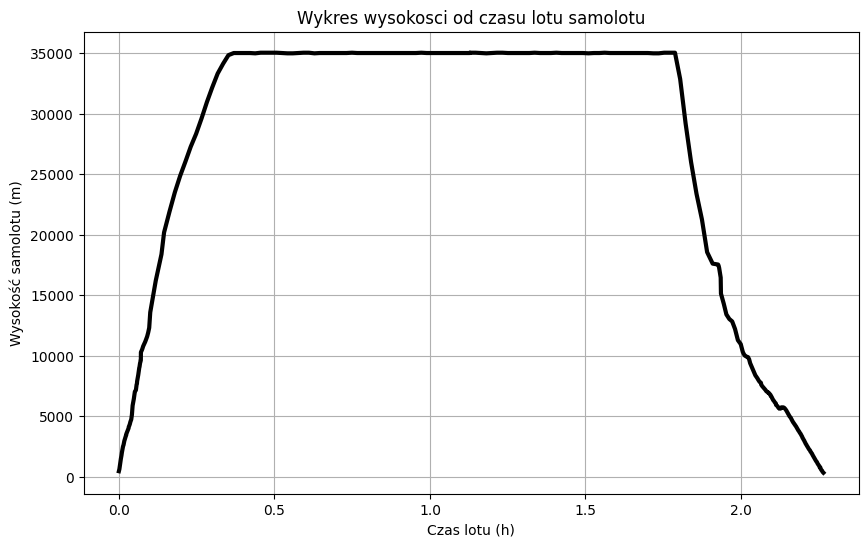

In [239]:
# wykonaj wykres Skyplot odleglosc do samolotu / azymut
import matplotlib.pyplot as plt

# tworzenie tabel
czas_lotu = []  
wysokosc_samolotu = []

# zmiana jednostki czasu na godziny
data[:,0] = data[:,0]/3600
# oblicz czas lotu 
for i, (fi, lam, h, v) in enumerate(latLonAlt_plane):
    czas_lotu.append(data[i,0]-data[0,0])
    wysokosc_samolotu.append(h)

# Tworzenie wykresu
plt.figure(figsize=(10, 6))  # Rozmiar wykresu
plt.plot(czas_lotu, wysokosc_samolotu, marker='', linestyle='-', color='black', linewidth=3)
plt.title('Wykres wysokosci od czasu lotu samolotu')
plt.xlabel('Czas lotu (h)')
plt.ylabel('Wysokość samolotu (m)')
plt.grid(True)

# Wyświetlenie lub zapisanie wykresu
plt.show() 

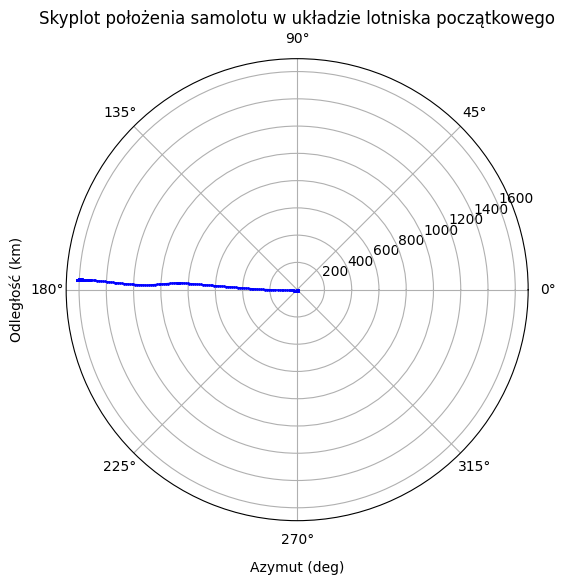

In [240]:
import matplotlib.pyplot as plt
import numpy as np

# Tworzenie tabel
azymut_samolotu = []
odleglosc_lotnisko_samolotu = []

# Oblicz azymut i odległość lotniska od samolotu
for i, (fi, lam, h, v) in enumerate(latLonAlt_plane):
    xyz = local_to_orto(np.deg2rad(fi), np.deg2rad(lam), h)
    xsl = xyz - airport_orto
    neu = r_matrix.T.dot(xsl)
    Az = np.rad2deg(np.arctan2(neu[1], neu[0]))
    s = np.sqrt(neu[0]**2 + neu[1]**2 + neu[2]**2) / 1000  # Odległość w kilometrach
    azymut_samolotu.append(Az)
    odleglosc_lotnisko_samolotu.append(s)

# Tworzenie wykresu skyplotu
plt.figure(figsize=(10, 6))
# ustaw 0 stopni na górze
plt.polar(np.deg2rad(azymut_samolotu), odleglosc_lotnisko_samolotu, 'bo-', linewidth=1, markersize=1)
plt.title('Skyplot położenia samolotu w układzie lotniska początkowego')
plt.xlabel('Azymut (deg)', labelpad=10)
plt.ylabel('Odległość (km)', labelpad=30)
plt.grid(True)

# Wyświetlenie wykresu skyplotu
plt.show()

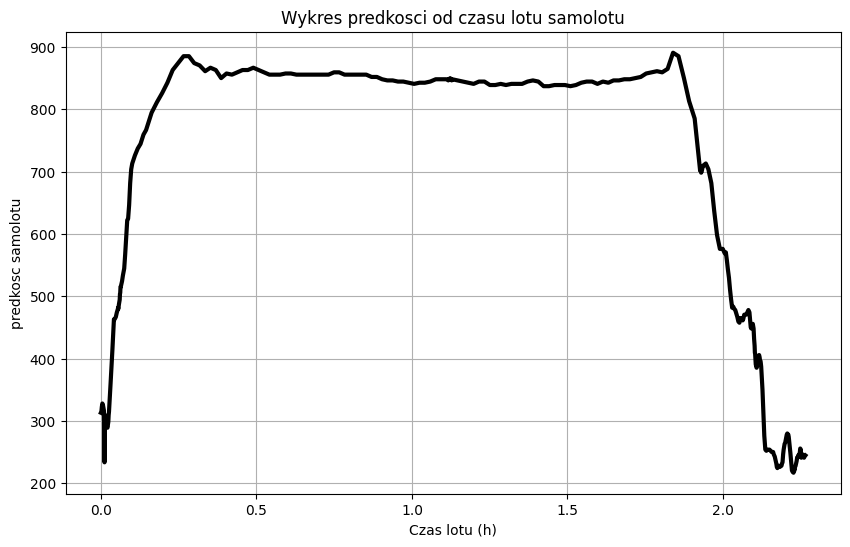

In [242]:
# wykonaj wykres predkosci od czasu lotu
import matplotlib.pyplot as plt

# tworzenie tabel
czas_lotu = []  
predkosc = []

# oblicz czas lotu 
for i, (fi, lam, h, v) in enumerate(latLonAlt_plane):
    # zmiana jednostki czasu na godziny
    czas_lotu.append(data[i,0]-data[0,0])
    # zmien jednostke predkosci na km/h
    predkosc.append(data[i,10]*1.852)

# Tworzenie wykresu
plt.figure(figsize=(10, 6))  # Rozmiar wykresu
plt.plot(czas_lotu, predkosc, marker='', linestyle='-', color='black', linewidth=3)
plt.title('Wykres predkosci od czasu lotu samolotu')
plt.xlabel('Czas lotu (h)')
plt.ylabel('predkosc samolotu')
plt.grid(True)

# Wyświetlenie lub zapisanie wykresu
plt.show() 